<div hidden=True>
    author: Marco Angius
    company: TomorrowData srl
    mail: marco.angius@tomorrowdata.io
    notebook-version: nov20
    
</div>

# Hands-on 4: Model Selection
This section aims to give some hints on how evaluating models and selecting parameters. We are going to use supervised models for this scope. We still employ Scikit-learn which offers also a good reference about [this topic](https://scikit-learn.org/stable/model_selection.html#model-selection). 

The agenda: 
- Cross Validation 
- Grid Search
- Evaluation Metrics

### mglearn library 
For visualizing the results obtained with our models we are going to employ an existing library made by Andreas C. Muller (author of the book *Introduction to Machine Learning with Python*). The library is available in the [github repository](https://github.com/amueller/mglearn).

In [157]:
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, recall_score, precision_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

## Cross Validation
In the previous notebooks we have already used `train_test_split` for keeping part of the data outside the model training in order to observe its generalization capabilities on unseen data. Cross Validation allows for more control over the data granting more stability and allows to use all the available data for the training.

It does it by splitting the dataset into *folds* and then using the k-1 folds for training and the left fold for testing, repeating the process until all folds are used as test set. This means that the model is trained k times, then the obtained scores on the single folds and the mean score is given.



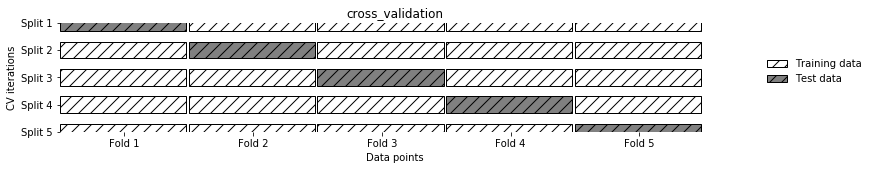

In [6]:
mglearn.plots.plot_cross_validation()

<div class="alert alert-info" role="alert">
    
<img src="./icons/list.png"  width="20" height="20" align="left"> &nbsp;  **Exercise 1: Cross-Validation**
- load the *iris* dataset 
- select a model for classification (suggestion: `sklearn.linear_model.LogisticRegression`)
- use `scores = cross_val_score(model, X, y, cv=numb_folds)` and check the result 
- try different *numb_folds* values

Why some folds performs perfectly and others are worse?

</div>

In [57]:
def print_pretty_scores(scores):
    print("Mean sore on test set: {:.3f}".format(scores.mean()))
    print("Std score on test set: {:3f}".format(scores.std()))
    for i, score in enumerate(scores):
        print("Fold {} - score: {:.3f}".format(i, score))

<div class="alert alert-info" role="alert">
    
<img src="./icons/list.png"  width="20" height="20" align="left"> &nbsp;  **Exercise 2: Stratified CV**
For classification we might want to preserve the distribution of classes across training and testing. Standard *cross_validation* does not allows this. We can use the `sklearn.model_selection.StratifiedKFold` for taking into account class distributions.

- use the iris dataset
- instantiate `skf = StratifiedKFold(n_splits)` 
- use it over the iris dataset by passing the strategy to the `cross_val_score(cv=skf)` 
- compare the results using `kf = KFold(n_splits, shuffle=False)`

What if we do not perform shuffle?

</div>

In [68]:
pd.DataFrame(np.concatenate((y.reshape(-1,1), np.ones((len(y), 1))), axis=1), 
             columns=["classes", "count"]).groupby("classes").count()

,count
classes,
0.0,50
1.0,50
2.0,50


<div class="alert alert-warning" role="alert">
    
<img src="./icons/book.png"  width="20" height="20" align="left"> &nbsp;  **Theory: Large datasets**

In cases when datasets are large another useful cross-validation tool is *shuffle-split cv* which uses a different strategy for creating the splits. It creates n splits and allows for selecting the portion of training points and test points which do not need to sum to one. This is like subsampling the initial dataset and allows for controlling the number of splits without affecting the distribution of samples in the training and test sets. 

In scikit-learn `ShuffleSplit` and `StratifiedShuffleSplit` for classification are available for this purpose.

</div>

## GridSearch
Since now we have used supervised models which number of hyperparameters is limited. There are cases where a model can be tuned with many parameters. We are going to see one of this case with Support Vector Machines and the use of RBF (Radial Basis Function) as a kernel. 

<div class="alert alert-info" role="alert">
    
<img src="./icons/list.png"  width="20" height="20" align="left"> &nbsp;  **Exercise 3: Implementation of Grid Search**
We keep using the iris dataset (balanced version) for this tasks. 

- split the iris dataset in training and test using `train_test_split()`
- using the provided list of hyper-parameter `gamma` and `C: 
    - train the `sklearn.svm.SVC()` model using all combinations of the two 
    - save the best hyper-parameters and the best test score 
- print the best obtained results

</div>

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=7)

In [88]:
gamma = [0.001, 0.01, 0.1, 1, 10, 100]
C = [0.001, 0.01, 0.1, 1, 10, 100]

In [159]:
best_score = 0
best_model = (None, None)

for g in gamma:
    for c in C:
        ...

### GridSearch with CV
What we have missed before is that we have fitted the hyper-parameter search on the test data and we have been overconfident on selecting the best result we have obtained. Indeed, we do not have any information on how the model would behave with new data and due to we used the test for finding the best parameters we cannot use it for evaluating how good is the model. 

We should split the data again, keeping the test for evaluating the goodness of the model while using another split to select the best combination of hyper-parameters. This new portion, derived from the training data, is called **validation set**. We can use cross-validation applied to the training data for deriving different splits of training and validation sets. The combination with the highest mean score on the splits is selected. 

Once selected, all the data from the original training set is used to train the model on the found hyper-parameters. The test set is then used to assess the generalization of the model to new unseen data.

<div class="alert alert-info" role="alert">
    
<img src="./icons/list.png"  width="20" height="20" align="left"> &nbsp;  **Exercise 4: GridSearchCV**

Scikit-learn implement a model which performs both gridsearch and CV. Use the already defined dictionary which encodes the parameter grid and: 
- instantiate `gscv = GridSearchCV(model, param_grid, cv)` class passing a `SVC()` model and the parameters
- split the iris dataset in train and test sets
- fit the model on the training set 
- analyze the obtained scores with the `show_scores_gscv(gscv)` provided function
- evaluate the best model:
    - get the model `gscv.best_estimator`
    - evaluate score for test set

</div>

In [125]:
def show_scores_gscv(model):
    res = pd.DataFrame(model.cv_results_)
    return (
        res[res.columns[4:]].drop(columns="params")
        .set_index(["param_gamma", "param_C"])
        .sort_values("rank_test_score")[:5]
    )

In [126]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [128]:
X_train, X_test, y_train, y_test = train_test_split(iris_ds.data, iris_ds.target, random_state=100)

In [129]:
gscv = GridSearchCV(SVC(), param_grid, cv=3)

## Metrics: unbalancing in classification 
Let's consider the binary case: it may happen that the problem pushes the dataset to present much more samples of a class than the other. An example is when predicting a diagnosis for tumors for which we have the majority of cases to be negative and few samples to be positives. In such cases the dataset is said to be *unbalanced*. 

The presence of an unbalanced target distribution in the dataset may affect the model training and results.

<div class="alert alert-info" role="alert">
    
<img src="./icons/list.png"  width="20" height="20" align="left"> &nbsp;  **Exercise 5: Unbalanced Cases**
Using the provided dataset (the *digits* dataset casted to be binary) check the performances with:
- A dummy classifier `DummyClassifier`
- A decision tree classifier `DecisionTreeClassifier`
- A logistic regression `LogisticRegression`

Can you really state which is the best estimator? 
</div>

In [155]:
X, y = load_digits(return_X_y=True)
y = y == 3

### Confusion matrix, precision, recall and f-score
One way to evaluate unbalanced classification problems is to use a confusion matrix. This allows to check how many points are miss-classified, either a positive class classified as negative or a negative class classified as positive, or correctly classified. The terminology for the confusion matrix is: *True Negative* (TN), *True Positive* (TP), *False Negative* (FN) and *False Positives* (FP).

From these it is possible to define the following metrics: 
- **Precision**: $ \frac{TP}{TP+FP} $ optimizes the least number of FP miss classified
- **Recall**: $ \frac{TP}{TP+FN} $ optimizes the positive class correctly classified (minority one usually)
- **F-score**: $2 * \frac{precision * recall}{precision + recall} $ harmonic mean of precision and recall


<div class="alert alert-info" role="alert">
    
<img src="./icons/list.png"  width="20" height="20" align="left"> &nbsp;  **Exercise 6: Confusion Matrix**

- plot the confusion matrix for the three models used before using the `plot_confusion_matric(y_true, y_pred)` provided function
- use `recall_score`, `precision_score`, `f1_score` to print the obtained scores

Do you have a better idea of which model performs better ?
</div>

In [158]:
def plot_confusion_matrix(y_true, y_pred, classes=["three", "not_three"],
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

<hr>

<div hidden=True>
<img src="./icons/list.png"  width="20" height="20" align="left"> &nbsp; Icon made by <a href="https://www.flaticon.com/authors/smashicons" title="Smashicons">Smashicons</a> from <a href="https://www.flaticon.com/"             title="Flaticon">www.flaticon.com</a>

<img src="./icons/lightbulb.png"  width="20" height="20" align="left"> &nbsp;Icon made by <a href="https://www.flaticon.com/authors/pixelmeetup" title="Pixelmeetup">Pixelmeetup</a> from <a href="https://www.flaticon.com/"             title="Flaticon">www.flaticon.com</a>

<img src="./icons/new.png"  width="20" height="20" align="left"> &nbsp; Icon made by <a href="https://www.flaticon.com/authors/pixel-perfect" title="Pixel perfect">Pixel perfect</a> from <a href="https://www.flaticon.com/"             title="Flaticon">www.flaticon.com</a>

<img src="./icons/chemistry.png"  width="20" height="20" align="left"> &nbsp; Icon made by <a href="https://www.flaticon.com/authors/popcorns-arts" title="Icon Pond">Icon Pond</a> from <a href="https://www.flaticon.com/"             title="Flaticon">www.flaticon.com</a>

<img src="./icons/book.png"  width="20" height="20" align="left"> &nbsp; Icon made by <a href="https://www.flaticon.com/authors/popcorns-arts" title="Icon Pond">Icon Pond</a> from <a href="https://www.flaticon.com/"             title="Flaticon">www.flaticon.com</a>
    
</div>